In [1]:
import sys
import pdb
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil

In [2]:
latmin, latmax = 30, 50

# ----- get tendencies
utend       = putil.get_daily_variable('UTEND', latmin=latmin, latmax=latmax)
utendepfd   = putil.get_daily_variable('utendepfd', latmin=latmin, latmax=latmax)
utendresvel = putil.get_daily_variable('UTRESVEL', latmin=latmin, latmax=latmax)
utenddiff   = putil.get_daily_variable('UTDIFF', latmin=latmin, latmax=latmax)
# ----- nan insignificant values
utend_impact_filt       = utend['impact'].where(utend['pval'] < 0.05)
utendepfd_impact_filt   = utendepfd['impact'].where(utendepfd['pval'] < 0.05)
utendresvel_impact_filt = utendresvel['impact'].where(utendresvel['pval'] < 0.05)
utenddiff_impact_filt   = utenddiff['impact'].where(utenddiff['pval'] < 0.05)

# ----- get tendencies
utendi       = putil.get_daily_variable('UTEND_INT', latmin=latmin, latmax=latmax)
utendepfdi   = putil.get_daily_variable('UTEPFD_INT', latmin=latmin, latmax=latmax)
utendresveli = putil.get_daily_variable('UTRESVEL_INT', latmin=latmin, latmax=latmax)
utenddiffi   = putil.get_daily_variable('UTDIFF_INT', latmin=latmin, latmax=latmax)
u            = putil.get_daily_variable('U', latmin=latmin, latmax=latmax)
# ----- nan insignificant values
utendi_impact_filt       = utendi['impact'].where(utend['pval'] < 0.05)
utendepfdi_impact_filt   = utendepfdi['impact'].where(utendepfd['pval'] < 0.05)
utendresveli_impact_filt = utendresveli['impact'].where(utendresvel['pval'] < 0.05)
utenddiffi_impact_filt   = utenddiffi['impact'].where(utenddiff['pval'] < 0.05)

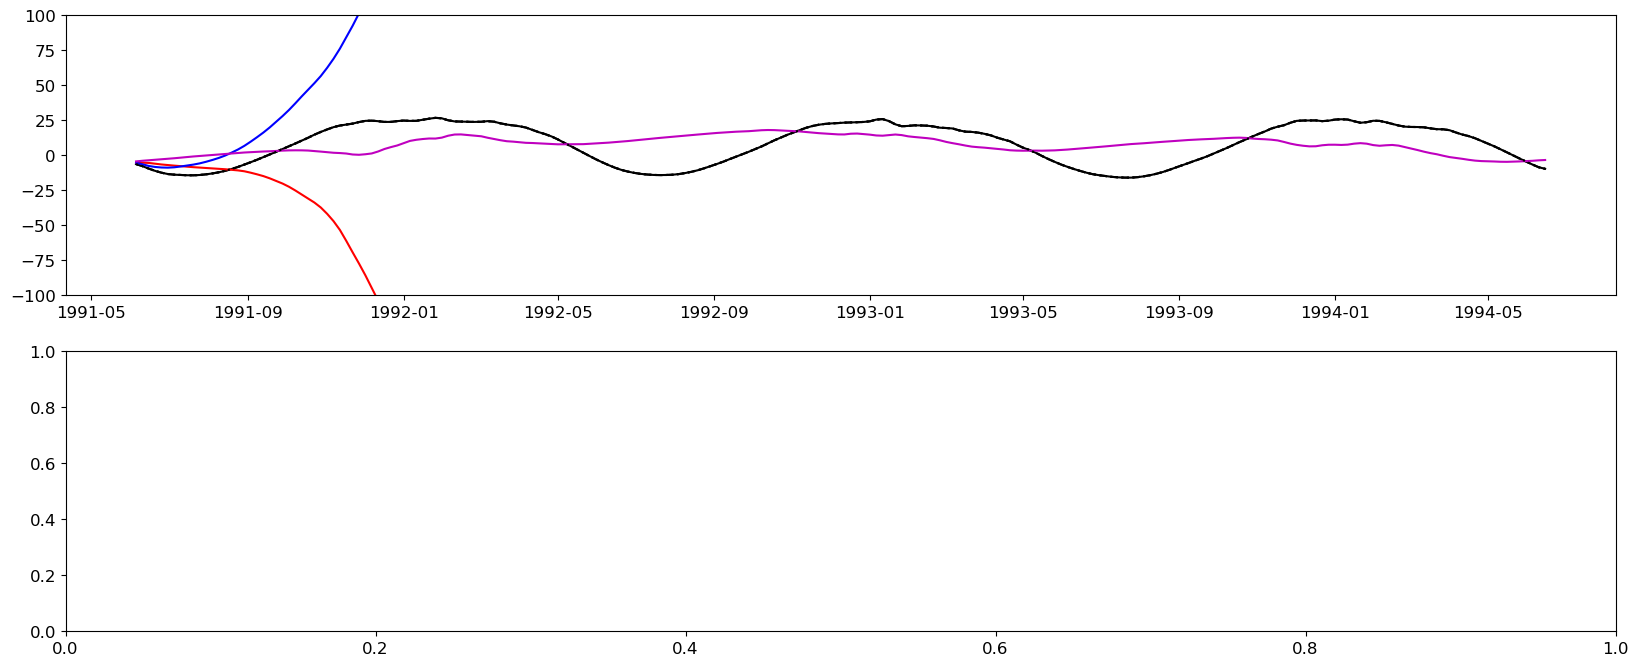

In [14]:
# ----- choose pressure level for analysis, get coords
parg = {'plev':10, 'method':'nearest'}
time = putil.to_datetime(u['ensmean'].time)

# ----- make figure
fig  = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# ----- plot wind, integrated tendencies
uu     = u['ensmean'].sel(**parg)
ut     = utendi['ensmean'].sel(**parg)
utepfd = utendepfdi['ensmean'].sel(**parg)
utrv   = utendresveli['ensmean'].sel(**parg)
utdf   = utenddiffi['ensmean'].sel(**parg)
ax1.plot(time, uu, '--k')
ax1.plot(time, ut, '-k')
ax1.plot(time, utepfd, '-r')
ax1.plot(time, utrv, '-b')
ax1.plot(time, utdf, '-m')
ax1.plot(time, -utdf+utrv+utepfd, ':k')

ax1.set_ylim([-100, 100])

plt.show()


In [ ]:
# same thing, but with cumulative sum beginning at specific time...

fig = plt.figure(figsize=(20, 20))
parg = {'plev':10, 'method':'nearest'}
timearg = {'time':slice(date(1991, 12, 1), date(1992, 5, 1))}
alltime = UTEPFD['impact'].time
alltime = alltime.sel(time=slice(alltime[0], date(1993, 6, 1)))
time = alltime.sel(**timearg)
time = [datetime(t.year,t.month,t.day) for t in time.values]

UU = U['impact'].sel(**parg).sel(time=slice(alltime[0], alltime[-1]))
UU0 = UU.sel(**timearg).isel(time=0)
factor = (24*60*60) # seconds per 10 days; each point (10-day average) should be expressing a tendency in m/s/(10 day)
# but because the current value's units are m/s/s... the tendencies appear much to small when integrated...

ue = UTEPFD['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
ue0 = ue.isel(time=0)
ue = ue-ue0 + UU0
urv = UTRESVEL['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
urv0 = urv.isel(time=0)
urv = urv-urv0 + UU0
udf = UTDIFF['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
udf0 = udf.isel(time=0)
udf = udf-udf0 + UU0
utot = ue+urv+udf
utot = (ue+urv+udf)-2*UU0


# Ok realizing something... WHAT I NEED: integrated tendecnies from time 0. I can choose a time to "zero" the tendency
# as POST PROCESSING. Then, impat can be calculated? and then adding the iitial condition is just a constant shift that
# should not change anything?? Or does the initial condition need to be set per-member?? Not clear. But I might already
# have the data computed to do this (as the integration method 2, which was a cumulative trapezoid rule?), either way... 
# should probbaly polt it in BOTH impact and CF... need to write a separate function to do all of this for any choice of
# starting date PER-MEMBER, and then continue on with the impact computation code...
# yea so... currently in this little test I am doing this on the 10-daily averaged data... a terrible idea. The tendencies
# must be integrated before averaging, else they are uselessly smoothed out. It makes more sense, however, for the 
# integrated quantity to be averaged, since this one should vary over much longer timescales

# plot tendency impact and impact
ax1 = fig.add_subplot(311)
ax1.plot(time, ue, '-r', lw=2)
ax1.plot(time, urv, '-b', lw=2)
ax1.plot(time, udf, '-m', lw=2)
ax1.plot(alltime, UU, '--k', lw=2)
ax1.plot(time, utot, ':k', lw=2)
ax1.axhline(y=0)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    #ax.set_xlim([time[0], time[-1]])
    #ax.set_ylim([-1, 1])
    
# SAME THING FOR CF
#fig = plt.figure(figsize=(20, 20))
parg = {'plev':10, 'method':'nearest'}
timearg = {'time':slice(date(1991, 12, 1), date(1992, 5, 1))}
alltime = UTEPFD['cfmean'].time
alltime = alltime.sel(time=slice(alltime[0], date(1993, 6, 1)))
time = alltime.sel(**timearg)
time = [datetime(t.year,t.month,t.day) for t in time.values]

UU = U['cfmean'].sel(**parg).sel(time=slice(alltime[0], alltime[-1]))
UU0 = UU.sel(**timearg).isel(time=0)
factor = (24*60*60) # seconds per 10 days; each point (10-day average) should be expressing a tendency in m/s/(10 day)
# but because the current value's units are m/s/s... the tendencies appear much to small when integrated...

ue = UTEPFD['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
ue0 = ue.isel(time=0)
ue = ue-ue0 + UU0
urv = UTRESVEL['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
urv0 = urv.isel(time=0)
urv = urv-urv0 + UU0
udf = UTDIFF['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
udf0 = udf.isel(time=0)
udf = udf-udf0 + UU0
utot = (ue+urv+udf)-2*UU0

# plot tendency impact and impact
#ax1 = fig.add_subplot(311)
ax1.plot(time, ue, '-r', lw=2)
ax1.plot(time, urv, '-b', lw=2)
ax1.plot(time, udf, '-m', lw=2)
ax1.plot(alltime, UU, '--k', lw=2)
ax1.plot(time, utot, ':k', lw=2)
ax1.axhline(y=0)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    ax.set_xlim([alltime[0], alltime[-1]])
    #ax.set_ylim([-1, 1])
plt.show()